## Exploratory Data Analysis

In [417]:
## load packages
import os 
import pathlib
import gdown
import sklearn
import seaborn as sns
import pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import re
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from feature_processing import encode_multi_features, encode_categorical
pd.set_option('display.max_columns', None)

### file: BILLS
- Remove rows where 'status'=NA
- Remove dupliacted rows 
- Plot distribution of 'status'

In [262]:
bills = pd.read_parquet("../data/raw/chorus/bills.parquet") # load data frame
print(f"Number of rows in BILLS: {len(bills)}\nNumber of rows with status=NA: {len(bills[bills["status"].isna()])}")
bills = bills[bills["status"].notna()] #remove rows where status=NA (this is the outcome var)
print(f"Number of rows in BILLS when status=NA is removed: {len(bills)}")

Number of rows in BILLS: 588786
Number of rows with status=NA: 52079
Number of rows in BILLS when status=NA is removed: 536707


In [263]:
# duplicated state_unified_bill_id:
bills_dupl = bills[bills.duplicated(subset = "state_unified_bill_id", keep=False)]
print(f"number of state_unified_bill_id values that are present twice: {len(bills_dupl)/2}")
print(bills_dupl.value_counts("state"))
print(bills_dupl.value_counts(["state", "bill_suffix"])) 

# define index values of rows to remove
ind_suffix_A = bills_dupl[bills_dupl["bill_suffix"] == "A"].index.tolist() #(468)
ind_IL = bills_dupl.loc[(bills_dupl["state"] == "IL") & (bills_dupl["bill_chamber"] == "HJR")].index.tolist() #(2)
ind_TX_NJ = bills_dupl[(bills_dupl["state"].isin(["TX", "NJ"])) & (bills_dupl["date_overlap_jaccard"].isna())].index.tolist() #(896)
ind_WI = bills_dupl[(bills_dupl["state"] == "WI") & (bills_dupl["bill_suffix"].notna())].index.tolist() # (3)
dupl = ind_WI + ind_IL + ind_TX_NJ + ind_suffix_A

# remove rowms from BILLS
bills = bills.drop(dupl)
print(f"number of bills after duplictates have been removed: {len(bills)}")

number of state_unified_bill_id values that are present twice: 1369.0
state
NJ    1774
NE     936
TX      18
WI       6
IL       4
Name: count, dtype: int64
state  bill_suffix
NE     A              468
WI     DE               2
       JN               1
Name: count, dtype: int64
number of bills after duplictates have been removed: 535338


In [264]:
#set index to bill_id value (after dups have been removed these are unique)
bills.set_index("state_unified_bill_id", inplace=True) 
#create map of passed and failed bills to each bill id
bills_outcome = bills["status"].isin([4,5]).to_dict()
# create new col with binary pass/fail status
bills["pass"] = bills.index.map(bills_outcome)

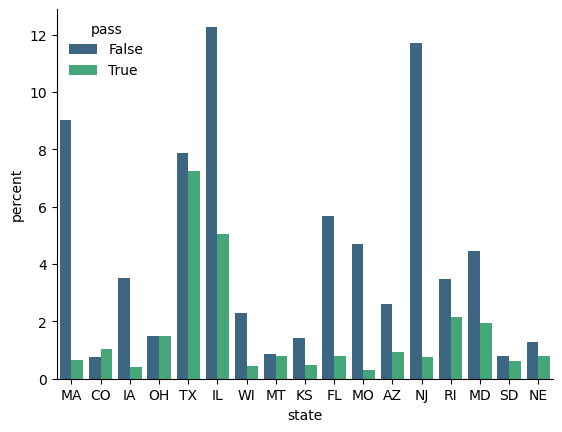

In [414]:
#plot outcomes(passed/failed) by state
p = sns.countplot(bills, x = "state", hue = "pass",stat = "percent", palette= "viridis")
sns.move_legend(p, "upper left", frameon = False)
sns.despine()

In [406]:
#change column to datetime format in other version : rm rows where last_action_date =0000-00-00
bills_dates = bills[bills["last_action_date"] != "0000-00-00"]
bills_dates["last_action_date"] = pd.to_datetime(bills_dates["last_action_date"].iloc[0:], format="%Y-%m-%d")
bills_dates["month_year"] = bills_dates["last_action_date"].dt.to_period("M")
bills_dates = pd.DataFrame(bills_dates.value_counts(["month_year", "pass"])).reset_index().sort_values("month_year").reset_index(drop=True)
bills_dates["month_year"] = bills_dates["month_year"].astype(str)

([<matplotlib.axis.XTick at 0x7f01f8bc7bc0>,
 [Text(1, 0, '2007'),
  Text(12, 0, '2008'),
  Text(24, 0, '2009'),
  Text(36, 0, '2010'),
  Text(48, 0, '2011'),
  Text(60, 0, '2012'),
  Text(72, 0, '2013'),
  Text(84, 0, '2014'),
  Text(96, 0, '2015'),
  Text(108, 0, '2016'),
  Text(120, 0, '2017'),
  Text(132, 0, '2018'),
  Text(144, 0, '2019'),
  Text(156, 0, '2020'),
  Text(168, 0, '2021'),
  Text(180, 0, '2022')])

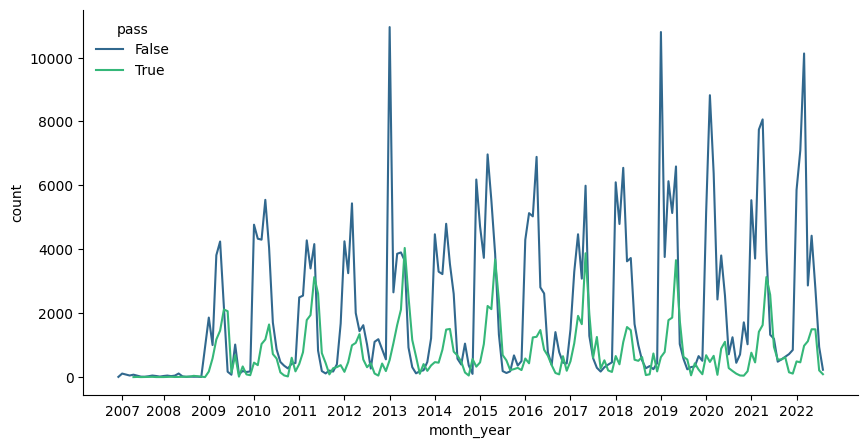

In [427]:
fig, ax = plt.subplots(figsize=(10, 5))
p = sns.lineplot(bills_dates, x = "month_year", y = "count", hue = "pass", 
                 palette="viridis")
sns.move_legend(p, "upper left", frameon=False)
sns.despine()
plt.xticks([1, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180],
           ['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015','2016','2017','2018','2019','2020','2021','2022'])


TypeError: Invalid object type at position 0

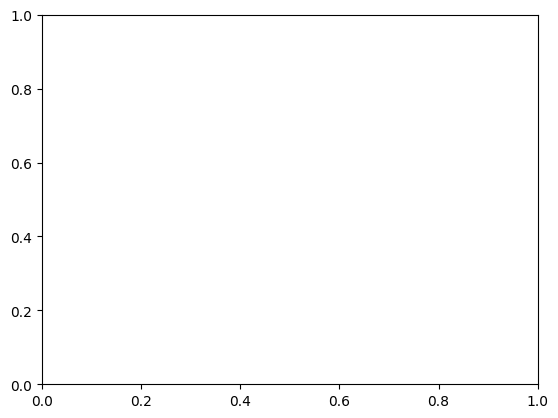

In [381]:
#bills_dates["month_year"]
sns.lineplot(bills_dates, x = "month_year", y = "count")

In [ ]:
bills["last_action_date"]

state_unified_bill_id
KS_HB_0000002001_2013       2014-05-30
KS_HB_0000002002_2013       2014-04-30
KS_HB_0000002011_2013       2013-05-08
KS_HB_0000002101_2013       2014-04-30
KS_SB_0000000118_2013       2013-04-05
                               ...    
MD_HB_0000001806_2012-X1    2012-05-14
MD_HB_0000001807_2012-X1    2012-05-14
MD_HB_0000001808_2012-X1    2012-05-14
MD_HB_0000001809_2012-X1    2012-05-14
MD_SB_0000001301_2012-X1    2012-05-22
Name: last_action_date, Length: 535338, dtype: object

In [30]:
path = open("bills_status.txt", 'w')
path.write(bills_test[["status", "last_action", "state_unified_bill_id", "sine_die"]].head(1000).sort_values(by = "status").to_string())
path.close()

In [12]:
positions = pd.read_parquet("data/positions.parquet")
blocks = pd.read_parquet("data/block_assignments.parquet")

In [14]:
blocks

,entity_id,block_0,block_1,block_2,block_3,block_4,block_5,block_6,state,record_type
0,MA_1,3283,150,0,12,3.0,3.0,2.0,MA,lobbying
1,MA_10,4139,20,27,26,0.0,3.0,2.0,MA,lobbying
2,MA_100,3291,209,42,6,0.0,3.0,2.0,MA,lobbying
3,MA_1000,1311,128,62,26,0.0,3.0,2.0,MA,lobbying
4,MA_1001,97,169,68,6,0.0,3.0,2.0,MA,lobbying
...,...,...,...,...,...,...,...,...,...,...
82631,RI_S_0000002245_2022,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82632,RI_H_0000007427_2018,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82633,RI_S_0000002475_2018,261,5,2,0,0.0,NaN,NaN,RI,lobbying
82634,RI_H_0000005127_2019,261,5,2,0,0.0,NaN,NaN,RI,lobbying


In [9]:
positions.loc[positions["state_unified_bill_id"].isin(bills_test["state_unified_bill_id"])]

,bill_version,client_name,lobbyist_rep_name,lobbyist_firm_name,position,start_date,end_date,year,record_type,session,description,committee,state,position_numeric,docket_number,docket_prefix,legiscan_bill_id,state_unified_bill_id,state_client_id,ncsl_metatopics,ncsl_topics
758626,None,Nebraska State Education Association,"McGuire, Mark D.",None,SUPPORT,2010-04-21 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
759457,None,Fremont Public Schools,"Nabb, Douglas L.",None,SUPPORT,2010-04-12 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_326,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760523,None,Nebraska State Education Association,"Sears, Jay",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760576,None,Nebraska State Education Association,"Guinan, Trish",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760629,None,Nebraska State Education Association,"Christiansen, Craig R.",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760781,None,Nebraska State Education Association,"Clayburn, Neal",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760834,None,Nebraska State Education Association,"Kilgarin, Karen",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760887,None,Nebraska State Education Association,"Scherer, Larry",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760940,None,Nebraska State Education Association,"Hoffman, Jerry",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...
760993,None,Nebraska State Education Association,"Mikkelsen, Brian",None,SUPPORT,2010-05-17 00:00:00+00:00,NaT,2010,lobbying,2010R,Amendments: \nDescription: Authorize leases on...,None,NE,1.0,None,None,150449.0,NE_L_0000000916_2009,NE_27,ncsl_metatopic__energy,ncsl_database__energy_legislation_tracking_dat...


In [3]:
#encoding features with different number of values
encode_multi_features(bills_test, "ncsl_metatopics", "; ")
encode_categorical(bills_test, ["state", "bill_chamber"])

(<Compressed Sparse Row sparse matrix of dtype 'float64'
 	with 28 stored elements and shape (14, 16)>,
 array(['state_AZ', 'state_FL', 'state_IL', 'state_MD', 'state_MO',
        'state_MT', 'state_NE', 'state_NJ', 'state_RI', 'state_WI',
        'bill_chamber_A', 'bill_chamber_H', 'bill_chamber_HB',
        'bill_chamber_LB', 'bill_chamber_S', 'bill_chamber_SB'],
       dtype=object))

In [ ]:
#extract representative subset to test feature preperation
#make metatopic coolumn a list instead of a single string 
#bills_test["ncsl_metatopics"] = bills_test["ncsl_metatopics"].str.split("; ")
#bills_test_sub = bills_test[["state", "ncsl_metatopics"]].to_numpy() #extract columns and turn df to array
#bills_test_sub

In [114]:
print(bills_test_sub)
print(bills_test_sub.shape)

enc = OneHotEncoder(sparse_output=True)                             #define one hot encode
enc.fit(bills_test_sub)                                              #fit enc to subset
bills_test_sub_tr = enc.transform(bills_test_sub)                    #transform subset
enc.get_feature_names_out()                                       

[['NE' list(['ncsl_metatopic__energy'])]
 ['MO' list(['ncsl_metatopic__elections_and_campaigns'])]
 ['MT' list(['ncsl_metatopic__energy'])]
 ['IL' list(['ncsl_metatopic__energy'])]
 ['FL' list(['ncsl_metatopic__technology_and_communication'])]
 ['MO' list(['ncsl_metatopic__elections_and_campaigns'])]
 ['IL' list(['ncsl_metatopic__ethics'])]
 ['MO' list(['ncsl_metatopic__transportation'])]
 ['MD' list(['ncsl_metatopic__transportation'])]
 ['IL' list(['ncsl_metatopic__technology_and_communication'])]
 ['WI'
  list(['ncsl_metatopic__fiscal', 'ncsl_metatopic__labor_and_employment'])]
 ['NJ' list(['ncsl_metatopic__transportation'])]
 ['RI' list(['ncsl_metatopic__labor_and_employment'])]
 ['AZ' list(['ncsl_metatopic__energy'])]]
(14, 2)


TypeError: Encoders require their input argument must be uniformly strings or numbers. Got ['list']

In [96]:
enc.categories_

[array(['AZ', 'FL', 'IL', 'MD', 'MO', 'MT', 'NE', 'NJ', 'RI', 'WI'],
       dtype=object),
 array(['ncsl_metatopic__elections_and_campaigns',
        'ncsl_metatopic__energy', 'ncsl_metatopic__ethics',
        'ncsl_metatopic__fiscal; ncsl_metatopic__labor_and_employment',
        'ncsl_metatopic__labor_and_employment',
        'ncsl_metatopic__technology_and_communication',
        'ncsl_metatopic__transportation'], dtype=object)]

In [35]:
#one hot encoding of states
states = bills["state"].unique()
enc = OneHotEncoder(categories=[states])

b_states = bills["state"][29:100].array.reshape(-1, 1)
b_states_new = enc.fit_transform(b_states)